In [1]:
def morgan_fp_gen(smiles, nBits=2048):
    m1 = AllChem.MolFromSmiles(smiles)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m1,2,nBits=nBits)
    return np.array(fp1)

def load_jmol(path, dimension=[224,224], zoom=1):
    jmol_image = Image.open(path)

    # Determine the aspect ratio by finding the shorter dimension
    width, height = jmol_image.size
    min_dim = min(width, height)

    # Calculate the left, top, right, bottom coordinates for cropping
    left = (width - min_dim) / 2
    top = (height - min_dim) / 2
    right = (width + min_dim) / 2
    bottom = (height + min_dim) / 2

    # Crop the image to square
    jmol_image = jmol_image.crop((left, top, right, bottom))

    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)

    # Apply zoom by cropping
    width, height = jmol_image.size
    left = width * ((1 - zoom) / 2)
    top = height * ((1 - zoom) / 2)
    right = width * ((1 + zoom) / 2)
    bottom = height * ((1 + zoom) / 2)
    jmol_image = jmol_image.crop((left, top, right, bottom))

    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)

    # Convert to numpy array
    jmol_image_array = np.array(jmol_image)

    return jmol_image_array

def load_exp_img_stack(path, dimensions=[224,224], zoom=1, normalize=True, interpolation='bilinear'):
    '''
    Obtains stack of experimental images from folder path and preprocesses 
    it so we can directly feed it to our CNN.

    Inputs:
    - path: Path of the folder containing the AFM images of the molecule.
    - dimensions: Desired dimensions for the output images. Default is [224,224].
    - zoom: Zoom level for the images. zoom <1 is zoom out and >1 zoom in. Default is 1.
    - normalize: If True, normalizes the output. Default is True.
    - interpolation: Interpolation method to be used. Options are 'bilinear', 'nearest', and 'bicubic'. 
                     Default is 'bilinear'.

    Output:
    - list of PIL images.
    '''
    interpolation_methods = {
        'bilinear': Image.Resampling.BILINEAR,
        'nearest': Image.Resampling.NEAREST,
        'bicubic': Image.Resampling.BICUBIC
    }

    torch_interpolation_methods = {
        'bilinear': transforms.InterpolationMode.BILINEAR,
        'nearest': transforms.InterpolationMode.NEAREST,
        'bicubic': transforms.InterpolationMode.BICUBIC
    }

    if interpolation not in interpolation_methods:
        raise ValueError(f'Interpolation method not recognized. Please use one of {list(interpolation_methods.keys())}.')

    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_path in path_list:        
        im_list.append(Image.open(im_path).resize(dimensions, resample=interpolation_methods[interpolation]).convert('L'))
        
    # Default parameters
    degrees = 0
    h_shift = 0
    v_shift = 0
    shear = 0

    for i in range(len(im_list)):
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], zoom, shear,
                                interpolation=torch_interpolation_methods[interpolation],
                                fill=im_list[i].getpixel((5, 5))
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    if normalize:
        normalize = transforms.Normalize(
            mean=[0.2855, 0.3973, 0.4424, 0.4134, 0.6759, 1.0664, 0.9904, 0.7708, 0.5748, 0.4055],
            std=[1.1341, 1.2528, 1.3125, 1.3561, 1.5844, 1.7763, 1.5447, 1.2683, 1.0588, 0.9308]) # for all K folders

        tensor_stack = normalize(tensor_stack)

    return tensor_stack



def load_exp_3_img(path, dimensions=[224,224], zoom=1):
    '''Obtains stack of experimental images from folder path and preprocess 
        it so we can directly feed it to our CNN

        INPUT: path of the folder containing the AFM images of the molecule

        OUTPUT: list of PIL images'''
    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_index in [1,4,7]:
        
        im_list.append(Image.open(path_list[im_index]).resize(dimensions, resample=Image.Resampling.BILINEAR).convert('L'))
        
    # Default parameters
        degrees = 0
        h_shift = 0
        v_shift = 0
        shear = 0

        
    for i in range(len(im_list)):
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], zoom, shear,
                                interpolation=transforms.InterpolationMode.BILINEAR,
                                fill=im_list[i].getpixel((5, 5))
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    normalize = transforms.Normalize(
        mean=[0.1487, 0.2229, 0.4580],
        std=[0.0853, 0.0969, 0.1840])
        

    tensor_stack = normalize(tensor_stack)

    return tensor_stack

In [2]:
# IMPORTS
# additional packages
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import argparse
import os
import time
import glob
from tqdm import tqdm
import scipy
import seaborn as sns
import rdkit.Chem.AllChem as AllChem
import sys
USER = os.getenv('USER')
sys.path.append(f'/home/{USER}/CODE/Pytorch-fingerprints/')
# torch packages
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights
import torchvision.transforms.functional as TF

from torchmetrics import MetricCollection
from torchmetrics.classification import MultilabelRecall, MultilabelPrecision, MultilabelF1Score

import torch.nn.functional as F
from torch.utils.data import Dataset

print('PyTorch version:', torch.__version__)

# custom functions
from utils.all_utils import train_test_split, compute_pos_weights, save_config, train_for_epoch, validate, \
                            balance_beta_pos_weights, tanimoto_torch, validate_tanimoto

from utils.models import ResNet3D, resnet_10_chan, effnet_10_chan, eff_net_bias_warmer, resnet_bias_warmer 

from utils.dataloader import QUAM

from utils.screening import fp_screening_function, load_img_stack, predict_fp, tanimoto_numpy





print('Packages loaded')


class configuration:
    def __init__(self):
        # EXPERIMENT PARAMETERS
        self.experiment_name = 'exp_imgs'
        self.n_fp = 1024  # number of fingerprints
        self.output_size = 9
        self.ratio = 0.95  # train/test ratio
        self.seed = 42

        # TRAINING PARAMETERS

        self.lr = 0.001  # learning rate
        self.dropout = 0.5 # Dropout2d probability
        # self.momentum = 0.9  # momentum of SGD optimizer
        self.weight_decay = 0  # L2 regularization constant
        self.batch_size = 50  # Training batch size
        self.test_batch_size = 50  # Test batch size
        self.epochs = 150  # Number of epochs
        self.bias_warmer = True # setting appropiate bias
        self.pos_weight_balancer = True #for bigger fingerprints, it helps balance precision and recall
        self.pos_weight_beta = 10
        # DATA AUGMENTATION PARAMETERS

        # Rotation
        self.rot_prob = 0.5  # prob of rotation in data augmentation
        self.max_deg = 180  # maximum degrees of rotation in data augmentation

        # Zoom
        self.zoom_prob = 0.3  # prob of applying zoom
        self.max_zoom = 0.3  # maximum zooming in/out

        # Translation
        self.shift_prob = 0.3  # probability of vertical or/and horizontal translation
        self.max_shift = 20  # translation

        # Shear
        self.shear_prob = 0.3  # probability of shearing
        self.max_shear = 10  # maximum shearing angle

## Create arguments object
args = configuration()
# Print experiment name
print('Experiment name:', args.experiment_name)


# make sure to enable GPU acceleration!
print(f'available devices: {torch.cuda.device_count()}')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.cuda.device(0)
#device = torch.device('cpu')
#print(device, torch.cuda.get_device_name(0))

# Set random seed for reproducibility
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)



PyTorch version: 1.12.1
Packages loaded
Experiment name: exp_imgs
available devices: 1


In [3]:
# Load data
data_path = f'/home/{USER}/QUAM-AFM/datasets/285k_train_15k_val_test_1024bits_df.gz'
dataset_df = pd.read_pickle(data_path)

train_df = dataset_df[dataset_df['split'] == 'train']
test_df = dataset_df[dataset_df['split'] == 'test']

##trainset = QUAM(args, train_df, mode='train')
##train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=1,
##                                           pin_memory=True)
##print('Train set samples:', len(trainset))
##
##testset = QUAM(args, test_df.dropna(), mode='test') #dropna for the experimental molecule
##test_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=False, num_workers=1,
##                                          pin_memory=True)
##
##print('Test set samples:', len(testset))

# FOR GPU

# model and metrics initialization

# model = ResNet3D(output_size=args.n_fp)
model = effnet_10_chan(output_size=args.n_fp, dropout=args.dropout)


models_path = f'/home/{USER}/CODE/Pytorch-fingerprints/experiments/300k_1024_all_ks_dropout_0_5/models'
checkpoint = torch.load(os.path.join(models_path, 'checkpoint_5_virtual_epoch_7.pth'))

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()


Train set samples: 285000
Test set samples: 279905


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(10, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Dropout2d(p=0.5, inplace=False)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
            (0): Conv2d(32, 16, kernel_siz

### Cis in gas

In [4]:
path = f'/home/{USER}/mDBPc_simulations_ppm_jaime/PROCESSED/mdbpc_gas-cis_manu' 
sample_df = test_df
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/mDBPc_simulations_ppm_jaime/PROCESSED/mdbpc_gas-cis_manu/mdbpc_gas_cis_0000.png',
 '/home/mgonzalez/mDBPc_simulations_ppm_jaime/PROCESSED/mdbpc_gas-cis_manu/mdbpc_gas_cis_0001.png',
 '/home/mgonzalez/mDBPc_simulations_ppm_jaime/PROCESSED/mdbpc_gas-cis_manu/mdbpc_gas_cis_0002.png',
 '/home/mgonzalez/mDBPc_simulations_ppm_jaime/PROCESSED/mdbpc_gas-cis_manu/mdbpc_gas_cis_0003.png',
 '/home/mgonzalez/mDBPc_simulations_ppm_jaime/PROCESSED/mdbpc_gas-cis_manu/mdbpc_gas_cis_0004.png',
 '/home/mgonzalez/mDBPc_simulations_ppm_jaime/PROCESSED/mdbpc_gas-cis_manu/mdbpc_gas_cis_0005.png',
 '/home/mgonzalez/mDBPc_simulations_ppm_jaime/PROCESSED/mdbpc_gas-cis_manu/mdbpc_gas_cis_0006.png',
 '/home/mgonzalez/mDBPc_simulations_ppm_jaime/PROCESSED/mdbpc_gas-cis_manu/mdbpc_gas_cis_0007.png',
 '/home/mgonzalez/mDBPc_simulations_ppm_jaime/PROCESSED/mdbpc_gas-cis_manu/mdbpc_gas_cis_0008.png',
 '/home/mgonzalez/mDBPc_simulations_ppm_jaime/PROCESSED/mdbpc_gas-cis_manu/mdbpc_gas_cis_0009.png']

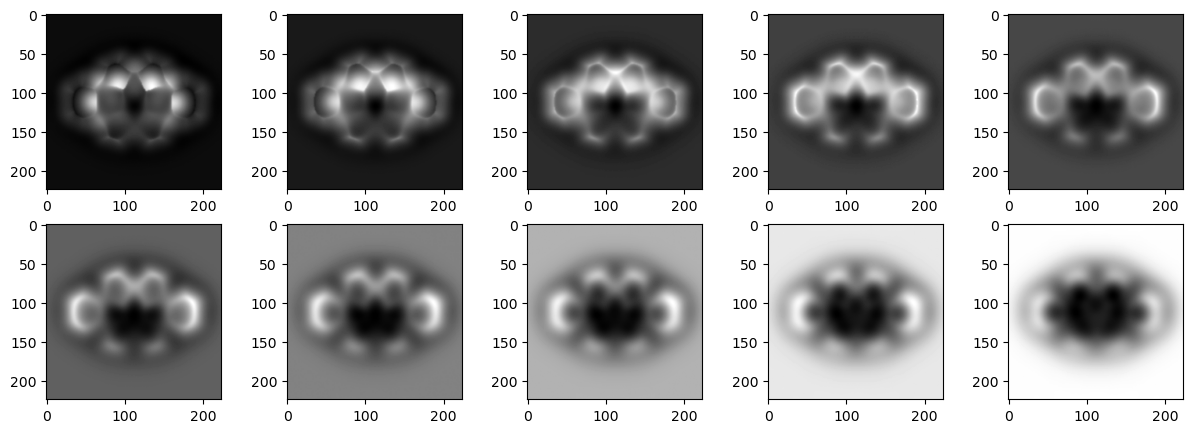

In [5]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1, normalize=True)

#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [6]:
CID = 1234512345
SMILES = 'c7ccc6c1ccc([nH]1)c2ccc([nH]2)c3ccccc3c4ccc(n4)c5ccc(n5)c6c7'
cis_morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan
print(cis_morgan_fp.sum())


experimental_df = sample_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':cis_morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
experimental_df

24


/tmp/ipykernel_6866/89392684.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = sample_df.append({'path':path,


,path,CID,SMILES,morgan_fp,split,corrugation
0,/scratch/dataset/quam/K-1/Conformer3D_CID_1000...,10001048,C1=CC=C2C=C3C(=CC2=C1)NC(=N3)C4=CC5=C(C=C4)N=C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,1.1767
1,/scratch/dataset/quam/K-1/Conformer3D_CID_1000...,10005,C(#N)N=C(N)N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0002
2,/scratch/dataset/quam/K-1/Conformer3D_CID_1001...,100128716,CC1=C(C2=NC(=CC(=C2C=C1)NCCCN)C)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0110
3,/scratch/dataset/quam/K-1/Conformer3D_CID_1001...,100175925,COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC=CO2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0530
4,/scratch/dataset/quam/K-1/Conformer3D_CID_1001...,100197007,COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC3=C(O2)C=CC4=CC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0856
...,...,...,...,...,...,...
279901,/scratch/dataset/quam/K-1/Conformer3D_CID_3410...,341027,C1OC2=C(O1)C(=O)C3=C(C2=O)C=CC(=C3)O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0035
279902,/scratch/dataset/quam/K-1/Conformer3D_CID_5392...,53921077,C1=CC(=CC=C1C=N)N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0008
279903,/scratch/dataset/quam/K-1/Conformer3D_CID_8238...,82382131,CC1=C2C=C(NC2=CC=C1)C3=NN=CC(=C3)C(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0034
279904,/scratch/dataset/quam/K-1/Conformer3D_CID_8241...,82418146,C1=C(N=C(O1)C=O)C(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0057


In [7]:
from rdkit import Chem

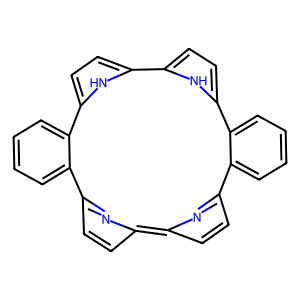

In [8]:
m = Chem.MolFromSmiles('c7ccc6c1ccc([nH]1)c2ccc([nH]2)c3ccccc3c4ccc(n4)c5ccc(n5)c6c7')
img = Chem.Draw.MolToImage(m)
img

In [9]:

exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1, normalize=True)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
10


In [10]:
output_df = fp_screening_function(exp_fp, experimental_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

Is the correct CID in the top k candidates? False


,path,CID,SMILES,morgan_fp,split,corrugation,tanimoto
73505,/scratch/dataset/quam/K-1/Conformer3D_CID_7798...,77987,C1=CC=C2C=CC2=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0004,0.428571
23591,/scratch/dataset/quam/K-1/Conformer3D_CID_1365...,136564,C1=CC=C2C(=C1)C3=CC=CC=C3C2=C4C5=CC=CC=C5C6=CC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0041,0.400000
112838,/scratch/dataset/quam/K-1/Conformer3D_CID_9170...,9170,C1=CC=C2C(=C1)C3=CC=CC=C3C4=CC=CC=C24,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0017,0.384615
30,/scratch/dataset/quam/K-1/Conformer3D_CID_1017...,101725283,C1=CC2=C3C=CC=C3C2=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0183,0.384615
1040,/scratch/dataset/quam/K-1/Conformer3D_CID_1302...,130275066,C1C2=C(COC3=CC=CC=C23)C4=CC=CC=C4O1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.6875,0.380952


In [11]:
output_df[output_df['CID'] == CID]

,path,CID,SMILES,morgan_fp,split,corrugation,tanimoto


In [12]:
for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = model(batched_tensor)

            fp_pred = (torch.sigmoid(predictions) > 0.5)


        exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

        gt_fp = cis_morgan_fp
        
        print('zoom:', zoom, 'tanimoto', round(tanimoto_numpy(exp_fp.squeeze(), gt_fp), 2))

Interpolation method: bilinear
zoom: 0.5 tanimoto 0.17
zoom: 0.6 tanimoto 0.14
zoom: 0.7 tanimoto 0.18
zoom: 0.8 tanimoto 0.17
zoom: 0.9 tanimoto 0.2
zoom: 1 tanimoto 0.21
zoom: 1.1 tanimoto 0.21
zoom: 1.2 tanimoto 0.22
zoom: 1.3 tanimoto 0.22
zoom: 1.4 tanimoto 0.21
zoom: 1.5 tanimoto 0.22
Interpolation method: nearest
zoom: 0.5 tanimoto 0.17
zoom: 0.6 tanimoto 0.15
zoom: 0.7 tanimoto 0.17
zoom: 0.8 tanimoto 0.17
zoom: 0.9 tanimoto 0.2
zoom: 1 tanimoto 0.21
zoom: 1.1 tanimoto 0.22
zoom: 1.2 tanimoto 0.22
zoom: 1.3 tanimoto 0.21
zoom: 1.4 tanimoto 0.21
zoom: 1.5 tanimoto 0.21
Interpolation method: bicubic
zoom: 0.5 tanimoto 0.15
zoom: 0.6 tanimoto 0.14
zoom: 0.7 tanimoto 0.16
zoom: 0.8 tanimoto 0.17
zoom: 0.9 tanimoto 0.2
zoom: 1 tanimoto 0.21
zoom: 1.1 tanimoto 0.21
zoom: 1.2 tanimoto 0.22
zoom: 1.3 tanimoto 0.21
zoom: 1.4 tanimoto 0.21
zoom: 1.5 tanimoto 0.22


In [49]:
trans_SMILES = "C7=CC=C6C1=CC=C([N]1[H])C2=CC=C([N]2)C3=CC=CC=C3C4=CC=C([N]4[H])C5=CC=C([N]5)C6=C7"
trans_morgan_fp = morgan_fp_gen(SMILES, nBits=1024)

for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = model(batched_tensor)

            fp_pred = (torch.sigmoid(predictions) > 0.5)


        exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

        gt_fp = trans_morgan_fp
        
        print('zoom:', zoom, 'tanimoto', round(tanimoto_numpy(exp_fp.squeeze(), gt_fp), 2))

Interpolation method: bilinear
zoom: 0.5 tanimoto 0.1
zoom: 0.6 tanimoto 0.11
zoom: 0.7 tanimoto 0.01
zoom: 0.8 tanimoto 0.01
zoom: 0.9 tanimoto 0.13
zoom: 1 tanimoto 0.15
zoom: 1.1 tanimoto 0.25
zoom: 1.2 tanimoto 0.23
zoom: 1.3 tanimoto 0.18
zoom: 1.4 tanimoto 0.18
zoom: 1.5 tanimoto 0.23
Interpolation method: nearest
zoom: 0.5 tanimoto 0.15
zoom: 0.6 tanimoto 0.13
zoom: 0.7 tanimoto 0.01
zoom: 0.8 tanimoto 0.0
zoom: 0.9 tanimoto 0.15
zoom: 1 tanimoto 0.15
zoom: 1.1 tanimoto 0.23
zoom: 1.2 tanimoto 0.21
zoom: 1.3 tanimoto 0.18
zoom: 1.4 tanimoto 0.19
zoom: 1.5 tanimoto 0.21
Interpolation method: bicubic
zoom: 0.5 tanimoto 0.14
zoom: 0.6 tanimoto 0.11
zoom: 0.7 tanimoto 0.01
zoom: 0.8 tanimoto 0.0
zoom: 0.9 tanimoto 0.13
zoom: 1 tanimoto 0.14
zoom: 1.1 tanimoto 0.25
zoom: 1.2 tanimoto 0.23
zoom: 1.3 tanimoto 0.18
zoom: 1.4 tanimoto 0.18
zoom: 1.5 tanimoto 0.24


In [51]:
tanimoto_numpy(cis_morgan_fp, trans_morgan_fp)

1.0

## Identifying 79464071


In [32]:
path = f'/home/{USER}/79464071_K1_cropped_selection'

sample_df = test_df
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/79464071_K1_cropped_selection/79464071_0004.jpg',
 '/home/mgonzalez/79464071_K1_cropped_selection/79464071_0005.jpg',
 '/home/mgonzalez/79464071_K1_cropped_selection/79464071_0006.jpg',
 '/home/mgonzalez/79464071_K1_cropped_selection/79464071_0007.jpg',
 '/home/mgonzalez/79464071_K1_cropped_selection/79464071_0008.jpg',
 '/home/mgonzalez/79464071_K1_cropped_selection/79464071_0009.jpg',
 '/home/mgonzalez/79464071_K1_cropped_selection/79464071_0010.jpg',
 '/home/mgonzalez/79464071_K1_cropped_selection/79464071_0011.jpg',
 '/home/mgonzalez/79464071_K1_cropped_selection/79464071_0012.jpg',
 '/home/mgonzalez/79464071_K1_cropped_selection/79464071_0013.jpg']

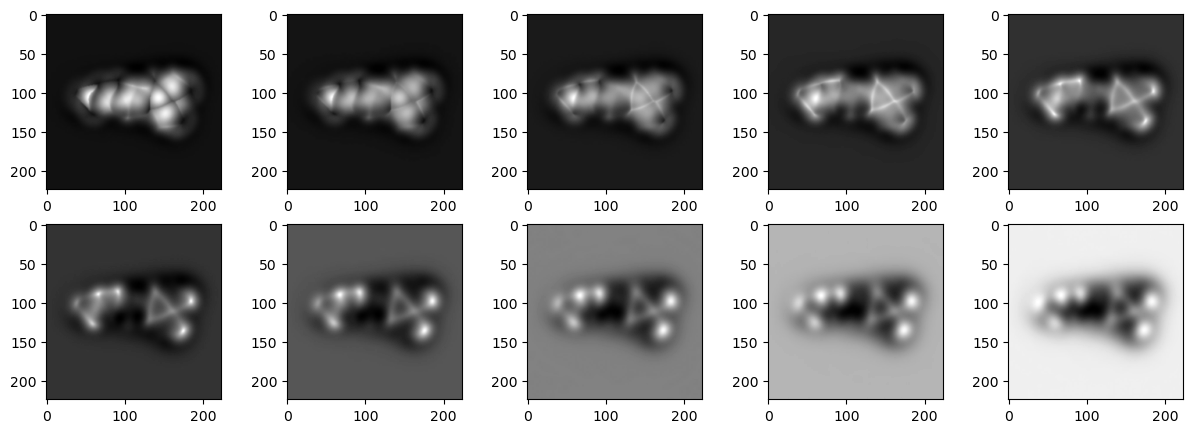

In [33]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1, normalize=True)

#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [34]:
CID = 79464071
sample_df[sample_df['CID']==CID] ## It's in the dataset

,path,CID,SMILES,morgan_fp,split,corrugation
152222,/scratch/dataset/quam/K-1/Conformer3D_CID_7946...,79464071,COC1=CC(=CC(=C1)NC(=O)COCCN)OC,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",test,0.0285


In [35]:

exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1, normalize=True)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
33


In [36]:
output_df = fp_screening_function(exp_fp, sample_df, top_k = 5)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

Is the correct CID in the top k candidates? True


,path,CID,SMILES,morgan_fp,split,corrugation,tanimoto
152222,/scratch/dataset/quam/K-1/Conformer3D_CID_7946...,79464071,COC1=CC(=CC(=C1)NC(=O)COCCN)OC,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",test,0.0285,1.000000
505944,/scratch/dataset/quam/K-1/Conformer3D_CID_1132...,113266708,COC1=CC(=CC(=C1)NC(=O)COCCN)F,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",test,0.0282,0.820513
2463,/scratch/dataset/quam/K-1/Conformer3D_CID_8859...,885906,COCC(=O)NC1=CC(=CC(=C1)OC)OC,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0062,0.666667
134264,/scratch/dataset/quam/K-1/Conformer3D_CID_2380...,2380419,CC(=O)OCC(=O)NC1=CC(=CC(=C1)OC)OC,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...",test,0.0132,0.657895
152072,/scratch/dataset/quam/K-1/Conformer3D_CID_7947...,79473303,COCC(=O)NC1=CC=C(C=C1)NC(=O)COCCN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",test,0.0267,0.641026
